In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

In [64]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

# Decision tree

In [57]:
df = pd.read_csv("data/prepared_data.csv")

## 1. First attempt without any optimisations
We use 4 features:
- text
- HasEmoji
- LengthCharacters
- DocumentType

### 1.1 Prepare data

In [3]:
X = df[['cleaned_text', 'HasEmoji', 'LengthCharacters', 'DocumentType']]
y = df['LabelMapped']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1.2 ColumnTransformer will allow us to get values from extra columns

In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(), 'cleaned_text'), 
        ('num', StandardScaler(), ['HasEmoji', 'LengthCharacters']),
        ('cat', OneHotEncoder(), ['DocumentType'])
    ]
)

### 1.3 Predict

In [6]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        max_depth=30,
        min_samples_split=4,
        min_samples_leaf=2,
        random_state=42
    ))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tfidf', TfidfVectorizer(),
                                                  'cleaned_text'),
                                                 ('num', StandardScaler(),
                                                  ['HasEmoji',
                                                   'LengthCharacters']),
                                                 ('cat', OneHotEncoder(),
                                                  ['DocumentType'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=30, min_samples_leaf=2,
                                        min_samples_split=4,
                                        random_state=42))])

In [7]:
y_pred = pipeline.predict(X_test)

### 1.4 Evaluate

In [8]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.59      0.69      0.64     17993
           0       0.44      0.42      0.43     12600
           1       0.69      0.60      0.64     20424

    accuracy                           0.59     51017
   macro avg       0.57      0.57      0.57     51017
weighted avg       0.59      0.59      0.59     51017



           Predicted -1  Predicted 0  Predicted 1
Actual -1         12498         2873         2622
Actual 0           4375         5289         2936
Actual 1           4398         3730        12296


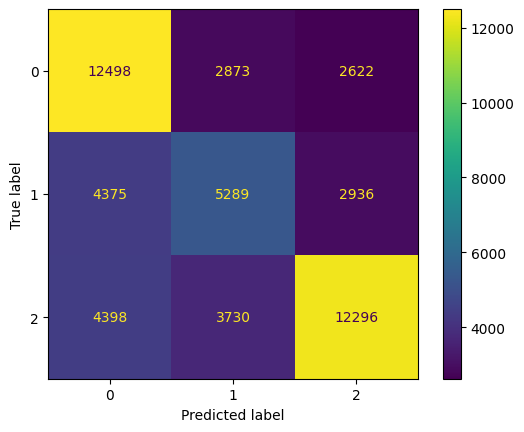

In [9]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual -1', 'Actual 0', 'Actual 1'], columns=['Predicted -1', 'Predicted 0', 'Predicted 1'])
print(cm_df)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

In [10]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.5896661897014721


## 2. Lookup most optimal hyperparameters

In [84]:
X = df[['cleaned_text', 'HasEmoji', 'LengthCharacters', 'DocumentType']]
y = df['LabelMapped']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(), 'cleaned_text'), 
        ('num', StandardScaler(), ['HasEmoji', 'LengthCharacters']),
        ('cat', OneHotEncoder(), ['DocumentType'])
    ]
)

In [86]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [90]:
param_grid = {
    'classifier__max_depth': [20, 30, 40],
    'classifier__min_samples_split': [10, 20, 30],
    'classifier__min_samples_leaf': [1, 2, 5],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
}

In [91]:
# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

/opt/conda/envs/dspt/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
135 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
76 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/envs/dspt/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/envs/dspt/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/dspt/lib/python3.11/site-packages/sklearn/pipeline.py", line 475, in fit

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('tfidf',
                                                                         TfidfVectorizer(),
                                                                         'cleaned_text'),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['HasEmoji',
                                                                          'LengthCharacters']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['DocumentType'])])),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [20, 30, 40],
                         'classifier__max_features': ['auto', 'sqrt', 'log2'],
                         'classifier__min_samples_leaf': [1, 2, 5],
                         'classifier__min_samples_split': [10, 20, 30]},
             scoring='accuracy')

In [92]:
# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters found: ", best_params)

# Predict on the test set using the best model
y_pred = best_model.predict(X_test)

# Print the classification report and accuracy
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Best parameters found:  {'classifier__max_depth': 40, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10}
              precision    recall  f1-score   support

          -1       0.58      0.27      0.37     17993
           0       0.40      0.07      0.12     12600
           1       0.44      0.88      0.59     20424

    accuracy                           0.46     51017
   macro avg       0.47      0.40      0.36     51017
weighted avg       0.48      0.46      0.39     51017

Accuracy: 0.4631005351157457


## 3. Random forest

In [74]:
X = df[['cleaned_text']]
y = df[['LabelMapped']]
X_train, X_test, y_train, y_test = train_test_split(X['cleaned_text'], y, test_size=0.2, random_state=42)

In [75]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', RandomForestClassifier(max_depth=100, n_estimators=100))
])

pipeline.fit(X_train, y_train)

/opt/conda/envs/dspt/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', RandomForestClassifier(max_depth=100))])

In [76]:
y_pred = pipeline.predict(X_test)

In [77]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.6203814414802908


In [78]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.71      0.70      0.71     17993
           0       0.77      0.01      0.03     12600
           1       0.57      0.93      0.71     20424

    accuracy                           0.62     51017
   macro avg       0.69      0.55      0.48     51017
weighted avg       0.67      0.62      0.54     51017



           Predicted -1  Predicted 0  Predicted 1
Actual -1         12585           24         5384
Actual 0           3572          168         8860
Actual 1           1502           25        18897


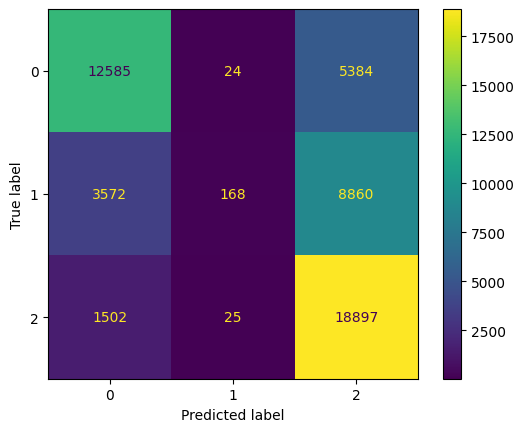

In [79]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual -1', 'Actual 0', 'Actual 1'], columns=['Predicted -1', 'Predicted 0', 'Predicted 1'])
print(cm_df)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()